***If any of the imports don't work, you can ssh into your docker instance, using:
   docker exec -it <docker_id> bash***

***and running:
    pip install <required_package>***

### Linear Regression on a (bad) House Pricing Dataset

In [1]:
import pandas as pd
import numpy as np

import pylab
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

### Read the house pricing data
** Note that our data comes in two seperate files - train and test.**

**However, the "test" data has no Y-column / prediction-column (SalesPrice) which means we won't be able to asses
our model's accuracy.**
**Instead, we'll only use the "train" data file, and use it to split out dataset into train/test datasets.**

In [2]:
houses_org_df = pd.read_csv('/home/jovyan/data/house_pricing/train.csv')
# houses_test = pd.read_csv('/home/jovyan/data/house_pricing/test.csv')

# this additional variable (houses_df) is in place so that I can manipulate the original DF
# additional times further along this notebook. The purpose was to not overwrite houses_org_df
houses_df = houses_org_df  
houses_df.describe()

IOError: File /home/jovyan/data/house_pricing/train.csv does not exist

In [216]:
# Setting Jupyter to show all the columns (instead of truncating the table with ...)
from IPython.display import display 
pd.options.display.max_columns = None

## Let's take a first quick peak at the data

In [217]:
houses_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Looks like our datasets have some missing data (which we'll need to fix)

In [218]:
houses_df.isnull().sum()[houses_df.isnull().sum() > 0]   # houses_df.isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

### Let's take a look at the columns that need fixing
#### (If some of these columns did not appear in the previous code-block, it must be because we found out about them only in the testing data)  :( <br>(Like a note from your future-self)

In [219]:
houses_df[['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFullBath', 'BsmtHalfBath', 'LotFrontage', 'MasVnrType', 
           'MasVnrArea', 'BsmtQual', 'BsmtUnfSF', 'Exterior1st', 'Exterior2nd', 'Functional', 'GarageArea', 
           'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 
           'GarageType', 'GarageYrBlt','GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 
           'MiscFeature', 'KitchenQual', 'MSZoning', 'SaleType', 'TotalBsmtSF', 'Utilities', ]].head(10)

,Alley,BsmtCond,BsmtExposure,BsmtFullBath,BsmtHalfBath,LotFrontage,MasVnrType,MasVnrArea,BsmtQual,BsmtUnfSF,Exterior1st,Exterior2nd,Functional,GarageArea,GarageCars,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,KitchenQual,MSZoning,SaleType,TotalBsmtSF,Utilities
0,NaN,TA,No,1,0,65.0,BrkFace,196.0,Gd,150,VinylSd,VinylSd,Typ,548,2,706,0,GLQ,Unf,SBrkr,NaN,Attchd,2003.0,RFn,TA,TA,NaN,NaN,NaN,Gd,RL,WD,856,AllPub
1,NaN,TA,Gd,0,1,80.0,None,0.0,Gd,284,MetalSd,MetalSd,Typ,460,2,978,0,ALQ,Unf,SBrkr,TA,Attchd,1976.0,RFn,TA,TA,NaN,NaN,NaN,TA,RL,WD,1262,AllPub
2,NaN,TA,Mn,1,0,68.0,BrkFace,162.0,Gd,434,VinylSd,VinylSd,Typ,608,2,486,0,GLQ,Unf,SBrkr,TA,Attchd,2001.0,RFn,TA,TA,NaN,NaN,NaN,Gd,RL,WD,920,AllPub
3,NaN,Gd,No,1,0,60.0,None,0.0,TA,540,Wd Sdng,Wd Shng,Typ,642,3,216,0,ALQ,Unf,SBrkr,Gd,Detchd,1998.0,Unf,TA,TA,NaN,NaN,NaN,Gd,RL,WD,756,AllPub
4,NaN,TA,Av,1,0,84.0,BrkFace,350.0,Gd,490,VinylSd,VinylSd,Typ,836,3,655,0,GLQ,Unf,SBrkr,TA,Attchd,2000.0,RFn,TA,TA,NaN,NaN,NaN,Gd,RL,WD,1145,AllPub
5,NaN,TA,No,1,0,85.0,None,0.0,Gd,64,VinylSd,VinylSd,Typ,480,2,732,0,GLQ,Unf,SBrkr,NaN,Attchd,1993.0,Unf,TA,TA,NaN,MnPrv,Shed,TA,RL,WD,796,AllPub
6,NaN,TA,Av,1,0,75.0,Stone,186.0,Ex,317,VinylSd,VinylSd,Typ,636,2,1369,0,GLQ,Unf,SBrkr,Gd,Attchd,2004.0,RFn,TA,TA,NaN,NaN,NaN,Gd,RL,WD,1686,AllPub
7,NaN,TA,Mn,1,0,NaN,Stone,240.0,Gd,216,HdBoard,HdBoard,Typ,484,2,859,32,ALQ,BLQ,SBrkr,TA,Attchd,1973.0,RFn,TA,TA,NaN,NaN,Shed,TA,RL,WD,1107,AllPub
8,NaN,TA,No,0,0,51.0,None,0.0,TA,952,BrkFace,Wd Shng,Min1,468,2,0,0,Unf,Unf,FuseF,TA,Detchd,1931.0,Unf,Fa,TA,NaN,NaN,NaN,TA,RM,WD,952,AllPub
9,NaN,TA,No,1,0,50.0,None,0.0,TA,140,MetalSd,MetalSd,Typ,205,1,851,0,GLQ,Unf,SBrkr,TA,Attchd,1939.0,RFn,Gd,TA,NaN,NaN,NaN,TA,RL,WD,991,AllPub


**Here we've got a function that handles different columns in different ways:**
* **Drops columns with too many missing values (so that they're not worth keeping around)**
* **Replacing values with zero or None (where it looks like it would be appropriate)**
* **Replacing missing numerical values with the mean of the column (where we think it would fit)**
* **Replacing missing categorical values with an OOV (out-of-vocabulary) expression (e.g, N/A)**

*Notice that our code doesn't currently support any other OOV values other than None/null.*

*What would happen if a new and unexpected value would appear in one of the categorical values???*

In [220]:
OOV_VALUE = 'NotAvailable'

def handle_bad_values(df):
    # Dropping unwanted columns (too many missing values will make them useless)
    df = df.drop(['Id', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

    # Replaceing some values with zero or None (Because, by looking at the data, it seems like that would fit there)
    df[['MasVnrType']] = df[['MasVnrType']].fillna(value='None')
    df[['MasVnrArea']] = df[['MasVnrArea']].fillna(value=0)

    #Replacing missing values in numerical columns with the mean of that feature
    cols_to_fill_with_mean = ['LotFrontage', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath',
                             'BsmtUnfSF', 'GarageArea', 'GarageCars', 'TotalBsmtSF', ]
    df[cols_to_fill_with_mean] = df[cols_to_fill_with_mean].fillna(df.mean()[cols_to_fill_with_mean])

    # Replacing missing categorical values with new value ("N/A") - this will be our OOV value (out of dictionary)
    cols_to_fill_with_na = ['MSZoning', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                           'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Utilities', 
                           'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual', 'MSZoning', 'SaleType', ]        
    df[cols_to_fill_with_na] = df[cols_to_fill_with_na].fillna(OOV_VALUE)
    
    return df

houses_df = handle_bad_values(houses_df)

In [221]:
# Good, no more missing data in our training set
houses_df.isnull().sum()[houses_df.isnull().sum() > 0]   # houses_df.isnull().sum()

Series([], dtype: int64)

### Getting a "feel" for a data - *Always a recommended first step*

**Even though we just want to see how to build a machine-learning model we can't really do that without understanding the data we're manipulating 
(unless we're OK with getting complete garbage as results).**

In [222]:
houses_df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.000000,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.000000,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.000000,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.000000,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.000000,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
5,50,RL,85.000000,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,700,10,2009,WD,Normal,143000
6,20,RL,75.000000,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,0,8,2007,WD,Normal,307000
7,60,RL,70.049958,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,350,11,2009,WD,Normal,200000
8,50,RM,51.000000,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,0,4,2008,WD,Abnorml,129900
9,190,RL,50.000000,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,Attchd,1939.0,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,0,1,2008,WD,Normal,118000


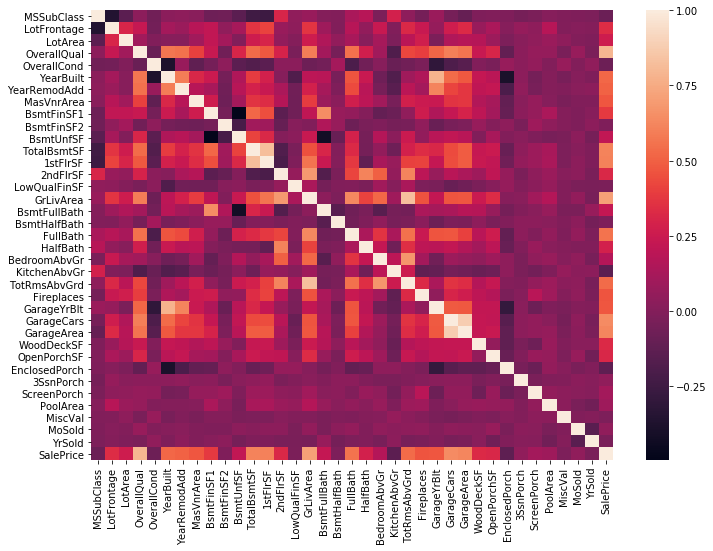

In [223]:
# Before building our model, it's always a good idea to get a "feel" for the data, 
# this will also come in handy when we'll want to assess if our results seem to make sense

# We can see some fields that seem to correlate with the end-price (OverallQual, GrLivArea, GarageCars, GarageArea)
from matplotlib import pyplot
import seaborn

a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

corr = houses_df.corr()
sns.heatmap(corr)

# But "OH-NO": A lot of our features are CATEGORICAL which doesn't work for ML models.
# We'll use something called "one-hot-encoding" on these and get back to our plot later.

### Let's start handeling our data by splitting our columns into categorical columns and numerical columns
#### Each will get a different treatment
(and then we'll continue getting our feel for the data)

In [224]:
numerical_features = [
    'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
    'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
    'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

categorical_features = [
    'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
    'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
    'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish',
    'GarageQual', 'GarageCond', 'PavedDrive', 'SaleCondition', 'SaleType'
]

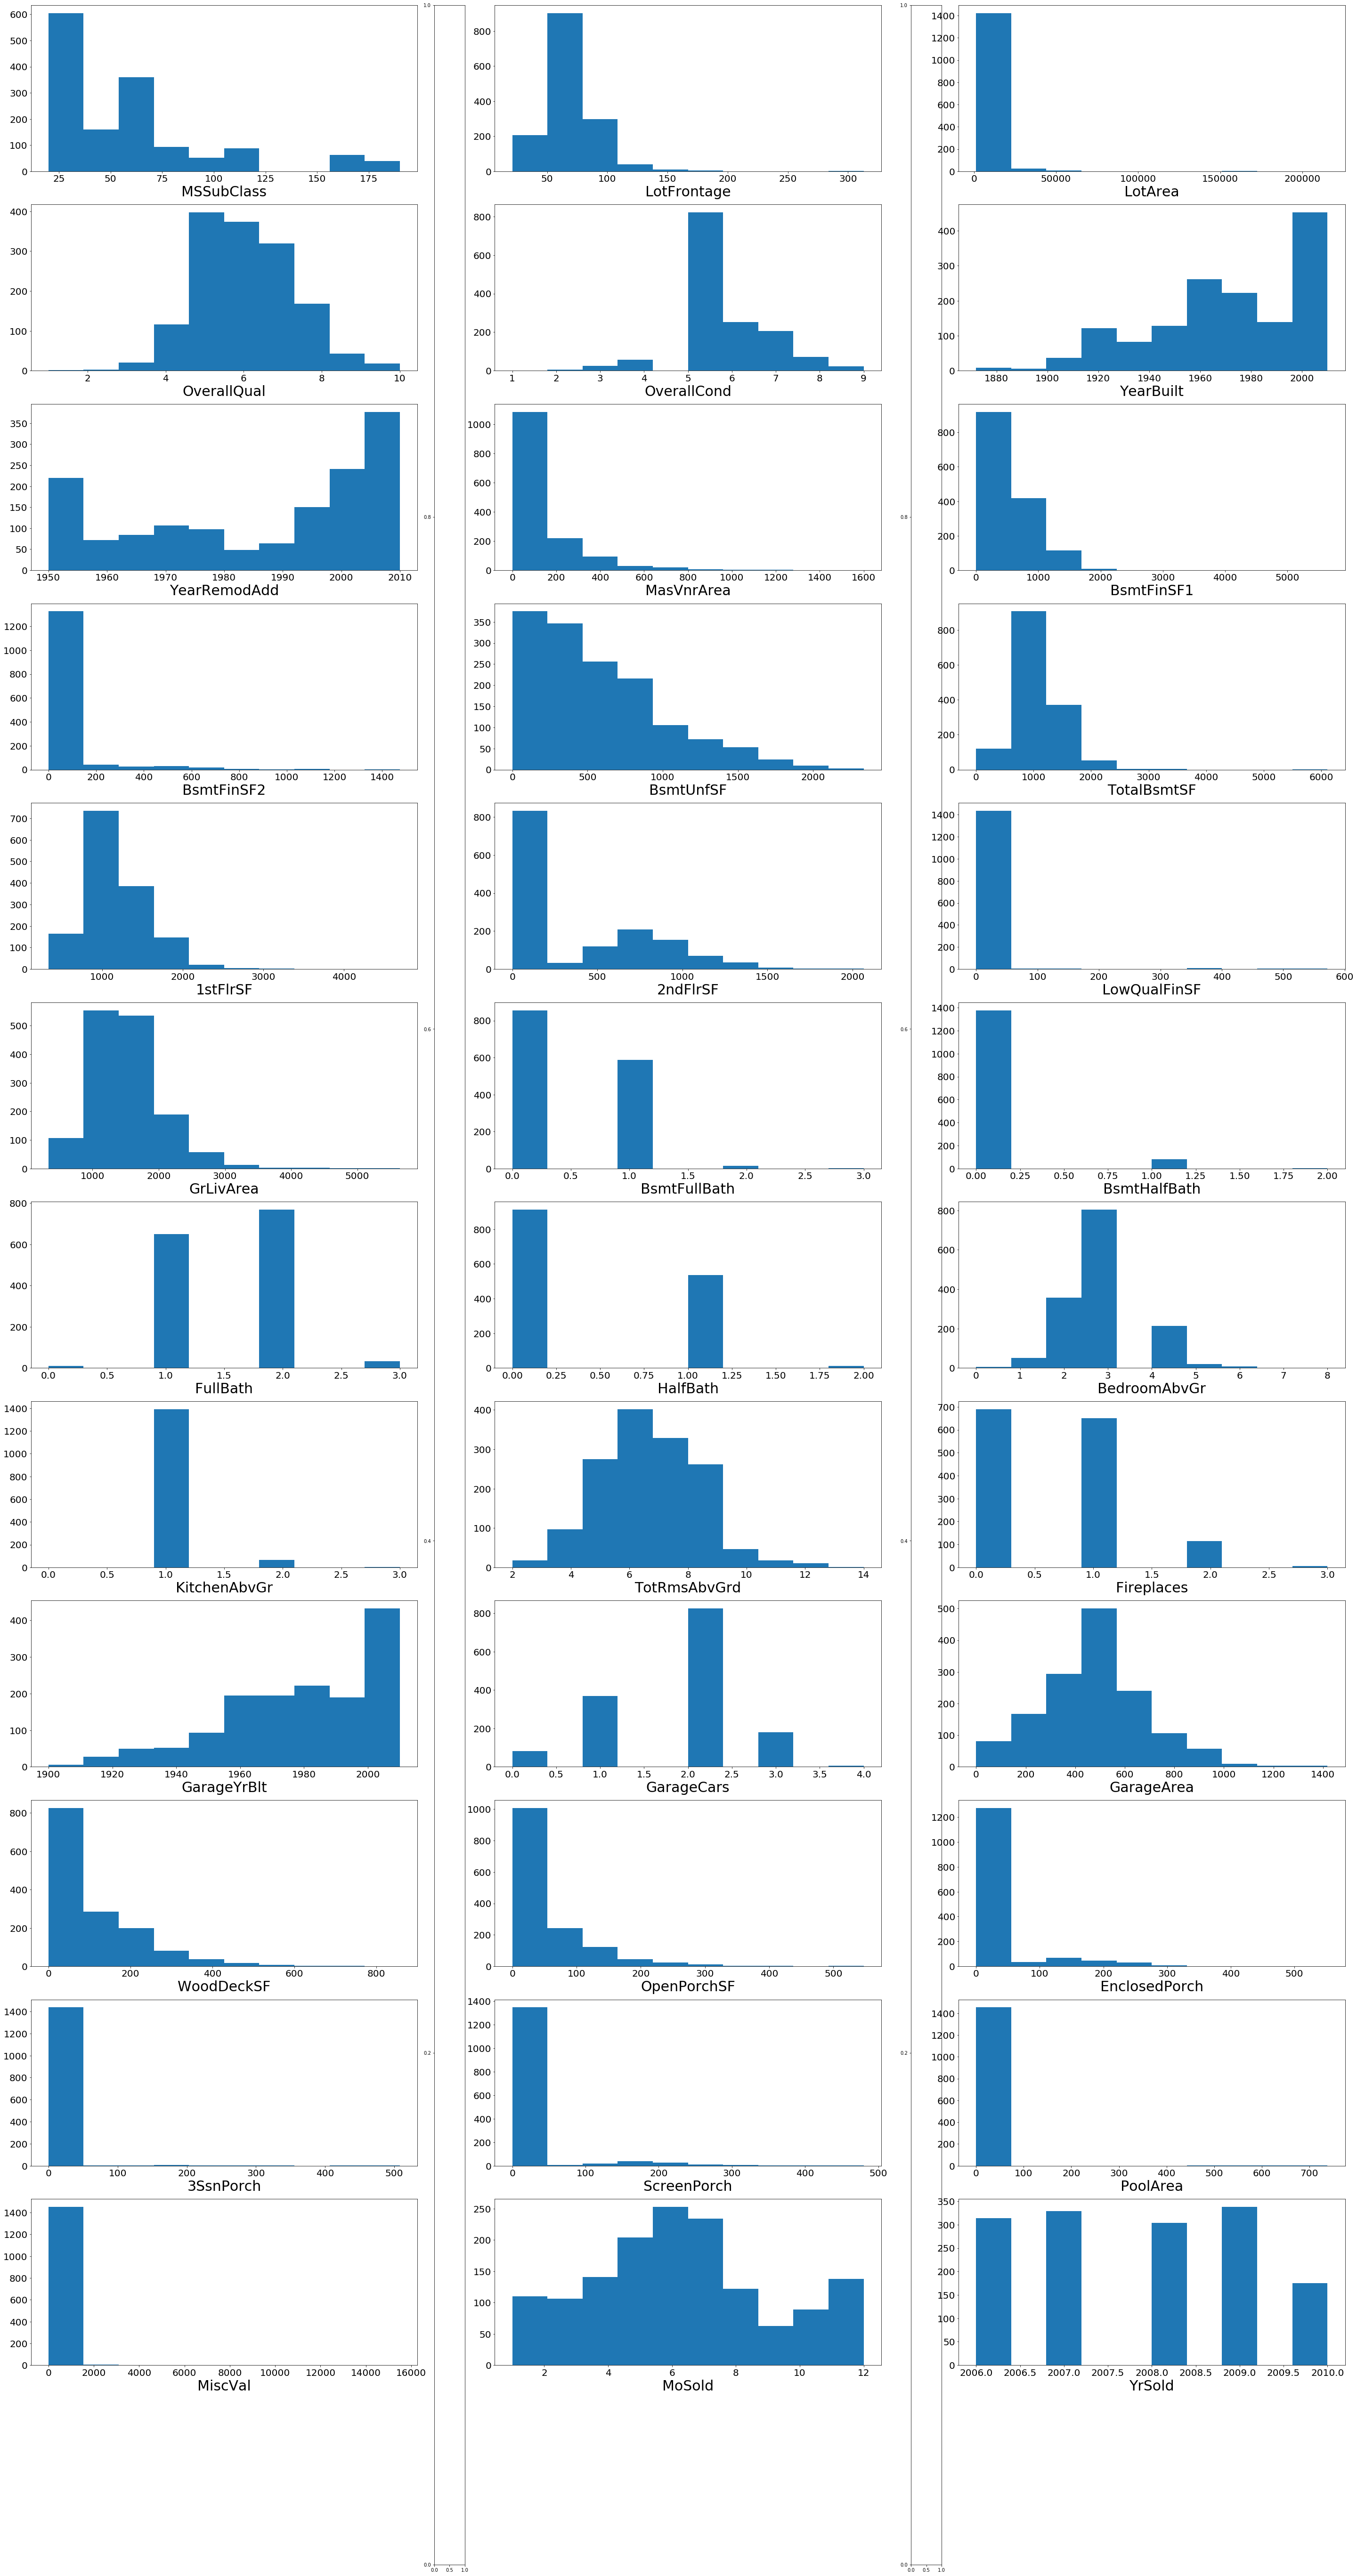

In [225]:
# We'll plot all our numercial features
def plot_mult_features(df, feature_names):
    a4_dims = (50, 100)
    fig, axs = plt.subplots(1,len(numerical_features), figsize=a4_dims)

    plt.figure(1)
    for idx, num_feature in enumerate(feature_names):
        cols = 3
        rows = int(len(numerical_features) / cols) + 1
        plt.subplot(rows, cols, idx + 1)
        plt.hist(df[num_feature], bins=10)
        plt.xlabel(num_feature, fontsize=30)
        plt.tick_params(labelsize=20)

    plt.show()

plot_mult_features(houses_df, numerical_features)

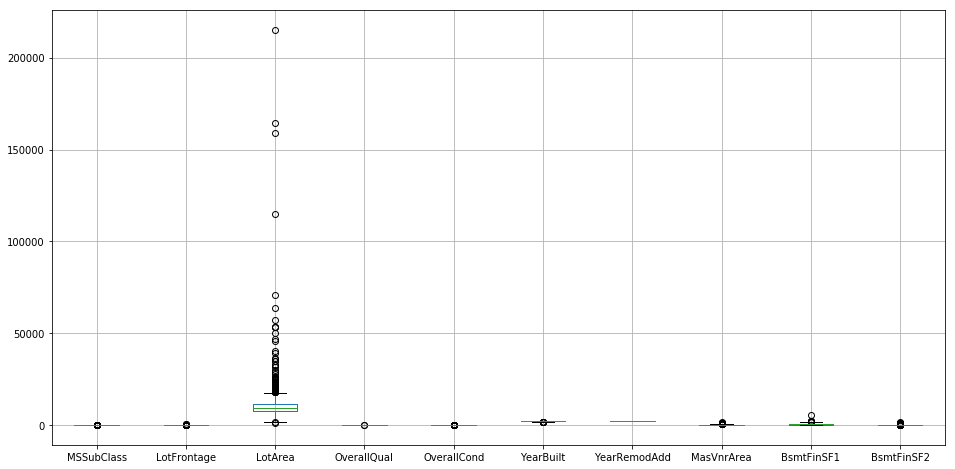

In [226]:
boxplot = houses_df.boxplot(column=numerical_features[0:10], figsize=(16, 8))

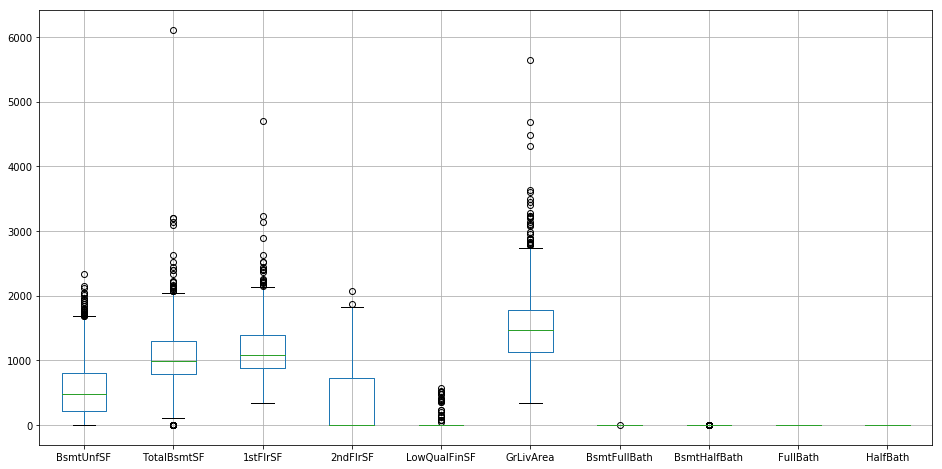

In [227]:
boxplot = houses_df.boxplot(column=numerical_features[10:20], figsize=(16, 8))

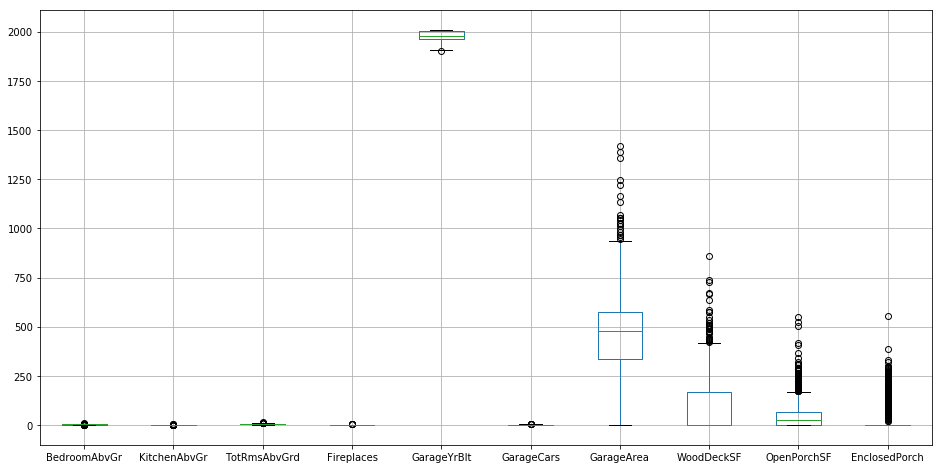

In [228]:
boxplot = houses_df.boxplot(column=numerical_features[20:30], figsize=(16, 8))

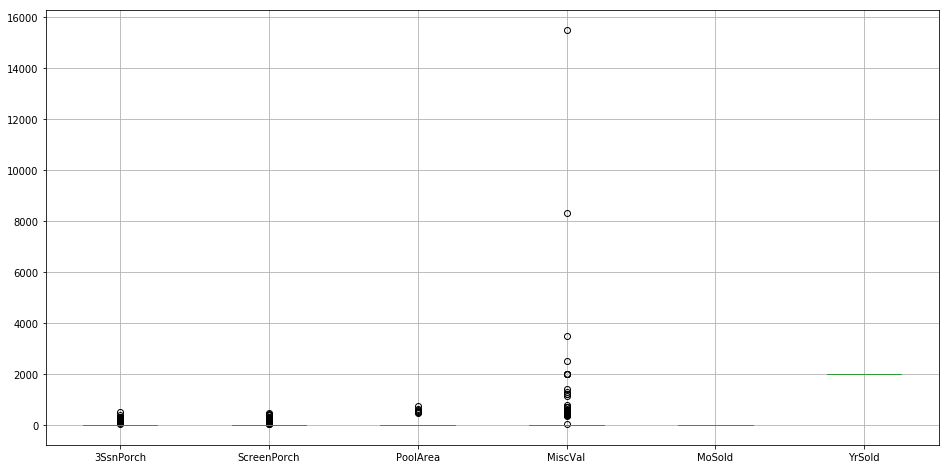

In [229]:
boxplot = houses_df.boxplot(column=numerical_features[30:40], figsize=(16, 8))

** For some reason, scaling the data affected our model results in a negative way.
(This might be because of the large number of outliers, but it is currently purely a hunch)**

It seems this example dataset isn't what we had hoped for, and the quality of our data is a fundamental element
in determining the success (or failure) of our predictions.
(in the real world, we would probably go back and re-collect it)

The large number of outliers would cause the *max-min range* in the scaling equation to become very large 
and skew results (although, at this point this is just a theory).
In addition, Linear Regression is an "invariant model" which means it is indifferent to scaling.
(that means that even if the scaling did not hurt our data, it would not make our predictions any better)
And that's because Linear Regression attempts to find the right coefficients for our features, which are always
*proportional* to their scale.

In [230]:
# And normalize them
def standard_normalization(input_df):
    df = input_df[numerical_features]
    df = (df - df.mean()) / df.std()
    
    input_df[numerical_features] = df
    return input_df
    
# houses_df = standard_normalization(houses_df)  # currently disabled
houses_df.head(10)    

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.000000,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.000000,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.000000,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.000000,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.000000,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
5,50,RL,85.000000,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,700,10,2009,WD,Normal,143000
6,20,RL,75.000000,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,0,8,2007,WD,Normal,307000
7,60,RL,70.049958,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,350,11,2009,WD,Normal,200000
8,50,RM,51.000000,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,0,4,2008,WD,Abnorml,129900
9,190,RL,50.000000,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,Attchd,1939.0,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,0,1,2008,WD,Normal,118000


** Another course of action that wasn't followed through was outlier removal.**

** (albiet, we took the lazy way out and just got rid of entire columns.. **
** a better solution would be removal of specific data-points based on IQR distance) **

** Interesting, we can see that our dataset has a *LOT* of outliers in it. **

** While working on this dataset, we thought about removing columns that have too many outliers in them - this course of action was abandoned after simple trial-and-error. It simply did not yield better results **
(and so, it was commented out)

In [231]:
def removing_outlying_features(df, numerical_features):
    cols_to_drop = ['LotArea', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'LowQualFinSF', 'GrLivArea', 
                    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                    'ScreenPorch', 'PoolArea', 'MiscVal']
    df = df.drop(cols_to_drop, axis=1)
    numerical_features = [col for col in numerical_features if col not in cols_to_drop]
    
    return numerical_features, df

# numerical_features, houses_df = removing_outlying_features(houses_df, numerical_features)  # currently disabled

In [232]:
houses_df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.000000,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.000000,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.000000,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.000000,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.000000,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
5,50,RL,85.000000,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,700,10,2009,WD,Normal,143000
6,20,RL,75.000000,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,0,8,2007,WD,Normal,307000
7,60,RL,70.049958,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,350,11,2009,WD,Normal,200000
8,50,RM,51.000000,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,0,4,2008,WD,Abnorml,129900
9,190,RL,50.000000,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,Attchd,1939.0,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,0,1,2008,WD,Normal,118000


## Encoding categorical features

**ML models work well with numbers, not strings - and since the order of categorical values usually have no meaning, we wouldn't want our models to tweak those values.
This is why we are using a 2-step solution: **
* **Label Encoding: turning strings / labels into arbitrary numbers**
* **One-Hot Encoding: turning these numbers into binary vectors**

For example: the values ['New-York', 'Tokyo', 'Tel-Aviv']
Could turn, at first, into the values [0, 1, 2], and then into:
[[1, 0, 0], [0, 1, 0], [0, 0, 1]]

** Note that this function does *NOT* handle new data coming in (only handles our train/test data)**.  
**For that, we'll need to be able to use our already fitted dictionaries, and also support OOV values**

In [233]:
# Although Pandas supplies us with a simple method to extract OHE features in a single step (called "pd.get_dummies")
# We'll use scikit-learn's Label-Encoder and One-Hot-Encoder - this is because we get to keep fitted encoder objects
# that will come in handy once we want to apply the exact same transformations to future data
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

def label_encoding(df, d_lbl=None):
    # if a label-dictionary is not supplied, we assume we should train/fit it
    if not d_lbl:
        d_lbl = defaultdict(LabelEncoder)  # this dict will hold our label-encoders, dict keys will be the column names

        for col in categorical_features:
            d_lbl[col].fit(df[col])
            d_lbl[col].classes_ = np.append(d_lbl[col].classes_, [OOV_VALUE]) # adding the OOV class to the encoder! (and yes, it's pretty hacky)
    
    for col in categorical_features:
        df[col] = d_lbl[col].transform(df[col])
    
    return d_lbl, df
    
fitted_label_dict, houses_df = label_encoding(houses_df)
houses_df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.000000,8450,1,5,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,6,2,2,6,3,2,706,6,0,150,856,1,0,1,5,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,1,2003.0,2,2,548,5,5,2,0,61,0,0,0,0,0,2,2008,8,4,208500
1,20,3,80.000000,9600,1,5,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,6,1,2,6,1,0,978,6,0,284,1262,1,0,1,5,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,1,1976.0,2,2,460,5,5,2,298,0,0,0,0,0,0,5,2007,8,4,181500
2,60,3,68.000000,11250,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,6,2,2,6,2,2,486,6,0,434,920,1,0,1,5,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,1,2001.0,2,2,608,5,5,2,0,42,0,0,0,0,0,9,2008,8,4,223500
3,70,3,60.000000,9550,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.0,3,6,0,4,1,3,0,216,6,0,540,756,1,2,1,5,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,5,1998.0,3,3,642,5,5,2,0,35,272,0,0,0,0,2,2006,8,0,140000
4,60,3,84.000000,14260,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,6,2,2,6,0,2,655,6,0,490,1145,1,0,1,5,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,1,2000.0,2,3,836,5,5,2,192,84,0,0,0,0,0,12,2008,8,4,250000
5,50,3,85.000000,14115,1,0,3,0,4,0,11,2,2,0,0,5,5,1993,1995,1,1,12,13,2,0.0,3,6,7,2,6,3,2,732,6,0,64,796,1,0,1,5,796,566,0,1362,1,0,1,1,1,1,3,5,6,0,1,1993.0,3,2,480,5,5,2,40,30,0,320,0,0,700,10,2009,8,4,143000
6,20,3,75.000000,10084,1,5,3,0,4,0,21,2,2,0,2,8,5,2004,2005,1,1,12,13,3,186.0,2,6,2,0,6,0,2,1369,6,0,317,1686,1,0,1,5,1694,0,0,1694,1,0,2,0,3,1,2,7,6,1,1,2004.0,2,2,636,5,5,2,255,57,0,0,0,0,0,8,2007,8,4,307000
7,60,3,70.049958,10382,1,0,3,0,0,0,14,4,2,0,5,7,6,1973,1973,1,1,6,6,3,240.0,3,6,1,2,6,2,0,859,1,32,216,1107,1,0,1,5,1107,983,0,2090,1,0,2,1,3,1,3,7,6,2,1,1973.0,2,2,484,5,5,2,235,204,228,0,0,0,350,11,2009,8,4,200000
8,50,4,51.000000,6120,1,5,3,0,4,0,17,0,2,0,0,7,5,1931,1950,1,1,3,17,2,0.0,3,6,0,4,6,3,6,0,6,0,952,952,1,2,1,1,1022,752,0,1774,0,0,2,0,2,2,3,8,2,2,5,1931.0,3,2,468,1,5,2,90,0,205,0,0,0,0,4,2008,8,0,129900
9,190,3,50.000000,7420,1,5,3,0,0,0,3,0,0,1,1,5,6,1939,1950,1,1,8,8,2,0.0,3,6,0,4,6,3,2,851,6,0,140,991,1,0,1,7,1077,0,0,1077,1,0,1,0,2,2,3,5,8,2,1,1939.0,2,1,205,2,5,2,0,4,0,0,0,0,0,1,2008,8,4,118000


In [234]:
# Next, we'll utilize the exact same trick with Scikit-Learn's One-Hot-Encoder
from sklearn.preprocessing import OneHotEncoder

def ohe_encoding(df, d_ohe=None):
    # if a ohe-dictionary is not supplied, we assume we should train/fit it
    if not d_ohe:
        d_ohe = {} # this dict will hold our OHEs, dict keys will be the column names

        # this part is a bit different - Scikit-Learn's one-hot-encoder requires a numpy array 
        # (not a Pandas dataframe)
        # We turn each relevant column in our dataframe into a 1D numpy array using the .values and .reshape methods.
        for col in categorical_features:
            if not d_ohe.get(col):
                d_ohe[col] = OneHotEncoder(handle_unknown='ignore', sparse=False)
            
            d_ohe[col].fit(df[col].values.reshape(-1, 1))
     
    for col in categorical_features:
        # The OHE returns a SPARSE array, and we use the "toarray" command in order to turn the output into a 
        # regular array (i.e, a DENSE array)
        # We then transform each relevant column, but that gives us an array of one-hot-encoded arrays.
        # In order to get these columns back into our dataframe, we turn the array of arrays into a small DF of its' 
        # own and concatanate them together.
        array_of_ohe_arrays = d_ohe[col].transform(df[col].values.reshape(-1, 1))  # .toarray()
        ohe_df = pd.DataFrame(array_of_ohe_arrays, columns = ['{c}_{i}'.format(c=col, i=idx) for idx in range(array_of_ohe_arrays.shape[1])])
        df = pd.concat([df, ohe_df], axis=1).drop([col], axis=1)
    
    return d_ohe, df

fitted_ohe_dict, houses_df = ohe_encoding(houses_df)
houses_df.head(10)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,MSZoning_5,Street_0,Street_1,LotShape_0,LotShape_1,LotShape_2,LotShape_3,LotShape_4,LandContour_0,LandContour_1,LandContour_2,LandContour_3,Utilities_0,Utilities_1,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_0,LandSlope_1,LandSlope_2,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Neighborhood_25,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_0,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,BldgType_5,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,HouseStyle_8,RoofStyle_0,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofStyle_6,RoofMatl_0,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_0,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior2nd_0,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,Exterior2nd_16,MasVnrType_0,MasVnrType_1,MasVnrType_2,MasVnrType_3,MasVnrType_4,ExterQual_0,ExterQual_1,ExterQual_2,ExterQual_3,ExterQual_4,ExterCond_0,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,ExterCond_5,Foundation_0,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Foundation_6,BsmtQual_0,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtQual_5,BsmtCond_0,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,BsmtCond_5,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,BsmtFinType1_7,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,BsmtFinType2_7,Heating_0,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,HeatingQC_0,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,HeatingQC_5,CentralAir_0,CentralAir_1,Electrical_0,Electrical_1,Electrical_2,Electrical_3,Electrical_4,Electrical_5,Electrical_6,KitchenQual_0,KitchenQual_1,KitchenQual_2,KitchenQual_3,KitchenQual_4,Functional_0,Functional_1,Functional_2,Functional_3,Functional_4,Functional_5,Functional_6,Functional_7,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,GarageFinish_0,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageFinish_4,GarageQual_0,GarageQual_1,GarageQual_2,GarageQual_3,GarageQual_4,GarageQual_5,GarageQual_6,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_4,GarageCond_5,GarageCond_6,PavedDrive_0,PavedDrive_1,PavedDrive_2,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SaleCondition_6,SaleType_0,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleType_9
0,60,65.000000,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,

# Stop, MODEL TIME!

### We're moving from Pandas conventions to scikit-learn's X and Y conventions for machine-learning.
** Also, notice we're NOT doing cross-validation here. :O **

X_train size: 978, X_test size: 482, y_train size: 978, y_test size: 482

Let's look at some predictions vs. labels (just to get a feel)
houses_PRED
[ 156146.21544092  347780.57792993   96746.86222283  177415.80237146
  326586.00539298   75457.73492308  238454.58669628  143854.48174873
   60258.37933877  150491.49519828  152687.25462852  104787.48048245
   44917.71410407  223499.74976703  177840.53861679  131653.1161027
  185575.43851365  121164.66913578  131629.79194148  221273.87185292]
----
houses_TEST
[154500 325000 115000 159000 315500  75500 311500 146000  84500 135500
 145000 130000  81000 214000 181000 134500 183500 135000 118400 226000]
----

Coefficients: 
 [  1.90966304e+02   3.80232087e+00   7.75971513e-01   7.35853981e+03
   4.45653144e+03   2.71529352e+02   1.30995311e+02   2.32814050e+01
   1.24264182e+01   5.81535533e+00  -7.80592146e-01   1.74611958e+01
   1.03891493e+01   2.58683897e+01  -1.14450063e+01   2.48125616e+01
   3.20424588e+03  -2.01912312e+02   4.11441304e

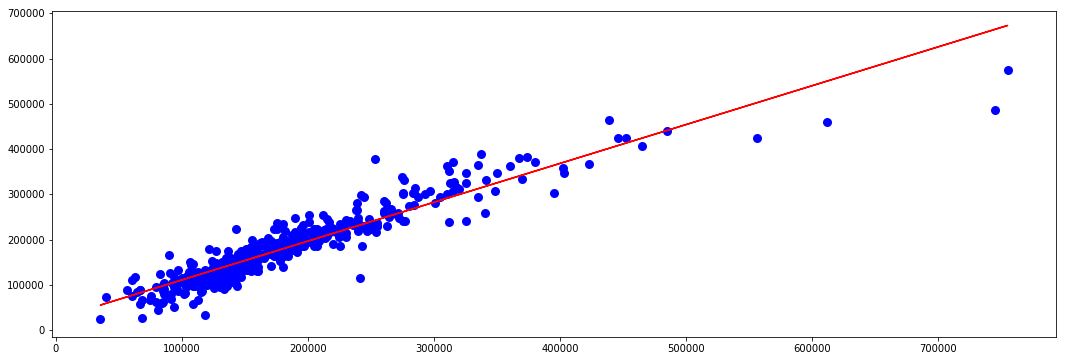

In [235]:
# First, it's time to split our dataset into train-test sets.
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import scipy

def train_linear_regression(df, y_col_name):
    X = df.drop([y_col_name], axis=1).values
    y = df[y_col_name].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # Checking that it worked as expected
    print('X_train size: {xtr}, X_test size: {xte}, y_train size: {ytr}, y_test size: {yte}\n'.format(
        xtr=len(X_train), xte=len(X_test), ytr=len(y_train), yte=len(y_test)))

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    houses_y_pred = regr.predict(X_test)
    
    print("Let's look at some predictions vs. labels (just to get a feel)")
    print('houses_PRED')
    print(houses_y_pred[0:20])
    print('----')
    print('houses_TEST')
    print(y_test[0:20])
    print('----\n')
    
    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # And the intercept
    print('The intercept: \n', regr.intercept_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(y_test, houses_y_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_test, houses_y_pred))

    # Plot outputs
    plt_dims = (18, 6)
    fig = plt.figure(figsize=plt_dims)
    
    #regression part
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test,houses_y_pred)

    line = slope*y_test+intercept
    plt.plot(y_test, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
    #end
    
    
    """
    for aaa in dir(c):
        print(aaa)
    """
    plt.scatter(y_test, houses_y_pred, color='blue', linewidth=3)
    plt.show()
    
    return regr

fitted_lr_model = train_linear_regression(houses_df, 'SalePrice')

#### Using our fitted model - let's use our original "test" data (with no Y-column data in it)

#### Remember that we don't support new lables :(

In [236]:
# Reading in original data - only top 10 rows
houses_new_data = pd.read_csv('/home/jovyan/data/house_pricing/test.csv') # [0:10]

# Applying the same transformations we used before let's prepare the data
houses_new_data = handle_bad_values(houses_new_data)

# This is a new transformation, we change all "new" values (that did not appear in the training set to our OOV value)
for cat in categorical_features:
    houses_new_data[cat] = houses_new_data[cat].map(lambda x: OOV_VALUE if x not in fitted_label_dict[cat].classes_ else x)

# We continue we our transformation pipeline
_, houses_new_data = label_encoding(houses_new_data, fitted_label_dict)  # notice we pass the dict!
_, houses_new_data = ohe_encoding(houses_new_data, fitted_ohe_dict)  # notice we pass the dict!

# Note: If scaling or outlier removal is reenabled, it should be reenabled here as well

# and we predict
acutal_predictions = fitted_lr_model.predict(houses_new_data.values)
print(acutal_predictions)

[ 120948.62288725  146970.24192609  183888.57168164 ...,  170240.05596779
  124944.29338879  217150.69044796]
